# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></div><div class="lev1 toc-item"><a href="#Loads-modules-and-packages" data-toc-modified-id="Loads-modules-and-packages-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loads modules and packages</a></div><div class="lev1 toc-item"><a href="#Auxiliar-Functions" data-toc-modified-id="Auxiliar-Functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Auxiliar Functions</a></div><div class="lev2 toc-item"><a href="#Load-CVS-file" data-toc-modified-id="Load-CVS-file-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Load CVS file</a></div><div class="lev2 toc-item"><a href="#1D-T1-Fit-and-data-plot" data-toc-modified-id="1D-T1-Fit-and-data-plot-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>1D T1 Fit and data plot</a></div><div class="lev2 toc-item"><a href="#Read-XTR-and-display-relevant-MRI-parameters" data-toc-modified-id="Read-XTR-and-display-relevant-MRI-parameters-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Read XTR and display relevant MRI parameters</a></div><div class="lev1 toc-item"><a href="#Defines-path-to-data-and-performs-file-conversion" data-toc-modified-id="Defines-path-to-data-and-performs-file-conversion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Defines path to data and performs file conversion</a></div><div class="lev1 toc-item"><a href="#Initial-QC" data-toc-modified-id="Initial-QC-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Initial QC</a></div><div class="lev2 toc-item"><a href="#Review-MRI-parameters" data-toc-modified-id="Review-MRI-parameters-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Review MRI parameters</a></div><div class="lev1 toc-item"><a href="#Review-Signal-vs-Flip-Angle-and-1D-fit" data-toc-modified-id="Review-Signal-vs-Flip-Angle-and-1D-fit-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Review Signal vs Flip Angle and 1D fit</a></div><div class="lev2 toc-item"><a href="#CSV-filename-structure" data-toc-modified-id="CSV-filename-structure-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>CSV filename structure</a></div><div class="lev2 toc-item"><a href="#Initial-QC---1D-T1-estimation-(ROIs)" data-toc-modified-id="Initial-QC---1D-T1-estimation-(ROIs)-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Initial QC - 1D T1 estimation (ROIs)</a></div><div class="lev2 toc-item"><a href="#Pre-registration-T1-map" data-toc-modified-id="Pre-registration-T1-map-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Pre-registration T1 map</a></div><div class="lev1 toc-item"><a href="#Performs-image-registration" data-toc-modified-id="Performs-image-registration-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Performs image registration</a></div><div class="lev1 toc-item"><a href="#Estimates-T1-maps" data-toc-modified-id="Estimates-T1-maps-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Estimates T1 maps</a></div><div class="lev1 toc-item"><a href="#Reads-the-results" data-toc-modified-id="Reads-the-results-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Reads the results</a></div>

# Description
Additional analysis on data


# Loads modules and packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np
import pylab as pl
from pynamika import *
from chanvesemaster import chanvese
from morphsnakesmaster import morphsnakes
import re
import os
import shutil
import glob
from skimage import data, io, filters, exposure
import nibabel as nib
import copy
import json
from scipy import signal
from scipy import stats
from scipy.ndimage import convolve1d
from scipy.ndimage import gaussian_laplace
from scipy.ndimage.filters import median_filter
from scipy.ndimage.measurements import maximum_position
from scipy import ndimage
from timeit import Timer
from pybxd.readBxdImage import read_bxd_image
def write2StudyIndex(Path2JsonFile, Key, Value):
    sifid = open(Path2JsonFile,'r')
    study_index = json.load(sifid)
    sifid.close()
    
    study_index[Key] = Value
    
    with open(Path2JsonFile,'w') as jFile:
        json.dump(study_index, jFile)
    print('***** File {} updated *****'.format(Path2JsonFile))


# Auxiliar Functions

In [2]:
def circle_levelset(shape, center, sqradius, scalerow=1.0):
    """Build a binary function with a circle as the 0.5-levelset."""
    grid = np.mgrid[list(map(slice, shape))].T - center
    phi = sqradius - np.sqrt(np.sum((grid.T)**2, 0))
    u = np.float_(phi > 0)
    return u

## Load CVS file

In [3]:
def loadImages(PATH2IMG):
    """
    
    """        
    IMFID  = nib.load(PATH2IMG)
    IMDATA = IMFID.get_data()
    
    return IMDATA

In [4]:
def ReadXTR(Path2XTR):
    
    d = {}
    with open(Path2XTR) as f:
        for line in f:
#             d=dict([line.split() for line in f]) -- It doesn't give the argument as number (i.e. float)
            (key, val) = line.split()
            d[key] = float(val)    
            
    return d

In [5]:
def MakeStdMatrix(Dyn_data,TimeInterval):
#Create a matrix which intensity depend on the movement present in Dyn_data over time (dimension 4)

    
    Dyn_data_f= Dyn_data
    #Dyn_data_f= convolve1d(Dyn_data_f,[+1,1,0,-1,-1],1)

    MeanSlice = np.nanmean(Dyn_data_f,3)
    #penalize high intensity pixels (organs), without advantage noise too much
    MeanSlice =MeanSlice/np.max(MeanSlice)+0.08
    MeanSlice[MeanSlice>1] = 1

    #Calculate the std matrix along the time dimension, but only on time interval (ie, half acquisition)
    MatrixStdCalc = np.zeros((Data.shape[0],Data.shape[1],NumberSlice ))
    for rrows in range(Data.shape[0]) :
        for ccols in range(Data.shape[1]) :
            for sslice in range(NumberSlice):
                Signal = Dyn_data_f[rrows,ccols,sslice,TimeInterval].squeeze() 
                MatrixStdCalc[rrows,ccols,sslice] = np.std(Signal)/(MeanSlice[rrows,ccols,sslice])
    #blur slightly images, bring noise and small details down            
    MatrixStdCalc1= median_filter(MatrixStdCalc,size=(1,5,1))  
    MatrixStdCalc1[MatrixStdCalc1<0]=0
    return MatrixStdCalc1


End of Section - Auxiliar Functions

# Defines path to data 

In [59]:
STUDYID    = 'L-ROY-16-23'
TYPEOFDATA = 'patient-data'
DATAID     = ['003']
CONFIGNAME = 'pulmolux-oe-ms2d-config'

ServerPath   = os.path.join(os.sep, 'Volumes' , 'Data')
Path2Data       = os.path.join(os.sep, ServerPath, STUDYID , TYPEOFDATA, DATAID[0] )
Path2Analysis    = os.path.join(Path2Data, 'analysis')
Path2Analyze     = os.path.join(Path2Data, 'analysis', 'analyze-raw-images')
Path2Tmp = os.path.join(Path2Data,'analysis', 'tmp')

In [60]:
DynPattern   = 'Dynamic_'
T1mapPattern = 'T1map_'
REF_SLICES = []
for dataset in DATAID:
    print(os.path.join(Path2Analyze , '*{}*'.format(DynPattern)))
    DynID         = glob.glob(os.path.join(Path2Analyze , '*{}*'.format(DynPattern)))
    get_snxx      = DynID[0].split('_')[1]
    print(get_snxx)
    REF_SLICES.append(get_snxx)
    print('For dataset {}, ref_slices={}'.format(dataset, get_snxx))
print('All done. Check there are no error messages before moving to the next cells')

/Volumes/Data/L-ROY-16-23/patient-data/003/analysis/analyze-raw-images/*Dynamic_*
sn000027
For dataset 003, ref_slices=sn000027
All done. Check there are no error messages before moving to the next cells


Scan the file names looking for slice number, Inversion times and number of repetitions. Save the pattern in dicitonaries

In [61]:
#Find the name of each slice
DictSl={}
DictTI={}
DictRep={}
TInames=[]
counter=0
counterTI=0
counterRep=0
Rep_counterDyn = 0
for dataset, snxxx in zip(DATAID, REF_SLICES):
    slxxx    = os.listdir(os.path.join(Path2Tmp, 'M', snxxx, 'tp0001'))    
    for sl in slxxx: 
        DictSl[sl] = counter
        counter = counter+1

for dataset, snxxx in zip(DATAID, REF_SLICES):
    ListOfFiles   = os.listdir(Path2Analyze)  
    for file in ListOfFiles: 
        if (file.find(T1mapPattern)>0) & file.endswith('.img') :
            if counterTI==0: #load one file, to understand the size
                Data= loadImages(os.path.join(Path2Analyze,file))
            TI_ind= (file.find('TI')) #this TI ind
            TIfile = file[TI_ind:TI_ind+6]
            if TInames.count(TIfile) == 0:
                TInames.append(TIfile)
                counterTI=counterTI+1
            Rep_ind= (file.find('tp')) #this TI ind
            Repfile = file[Rep_ind:Rep_ind+6]
            try: 
                index =int(DictRep[Repfile])
            except:
                DictRep[Repfile] = counterRep
                counterRep=counterRep+1
        if (file.find(DynPattern )>0) & file.endswith('.img') :
            Rep_ind= (file.find('tp')) #this TI ind
            Repetition = np.int(file[Rep_ind+2:Rep_ind+6])
            if Repetition>Rep_counterDyn:
                Rep_counterDyn=Repetition
  
NumbersTI = np.zeros((len(TInames),1))
for TI in range(len(TInames)):
    Num=re.findall(r'\d+',TInames[TI])
    NumbersTI[TI] = Num[0]
TInamesA=np.array(TInames)

inds = np.argsort(NumbersTI,0)
NumbersTISorted =np.sort(NumbersTI,0)
TInamesOrdered = TInamesA[inds]
TInamesO=list(TInamesOrdered )
for TI in range(TInamesOrdered.shape[0]):
    aa =(TInamesO[TI][0])
    DictTI[aa]=TI #dictionary ordered for TI values
print('All done. Check there are no error messages before moving to the next cells')  

All done. Check there are no error messages before moving to the next cells


Load files

In [62]:
#load all file in the dynamics - Acquisition 10 - in Dyn_data and the T1 maps data in T1_data
ListOfFiles = os.listdir(Path2Analyze)
counter=-1
NAverages=len(DictRep)
NumTI = len(DictTI)
NumberSlice= len(DictSl)
Dyn_data=np.zeros((Data.shape[0],Data.shape[1],NumberSlice ,Rep_counterDyn))# dim1,dim2,dim3,dyn
T1_data=np.zeros((Data.shape[0],Data.shape[1],NumberSlice ,NumTI,NAverages))
T1_data_reorder=np.zeros((Data.shape[0],Data.shape[1],NumberSlice ,NumTI*NAverages))


for file in ListOfFiles:
    if (file.find(get_snxx)>0) & file.endswith('.img') :
        DataF = loadImages(os.path.join(Path2Analyze,file));
        Sl_ind = (file.find('sl'))
        sliceInd = (file[Sl_ind:Sl_ind+5])
        indexSl = int(DictSl[sliceInd])
        if indexSl==0:
            counter=counter+1
        Dyn_data[:,:,indexSl,counter]= DataF.squeeze()
    elif (file.find(T1mapPattern)>0) & file.endswith('.img') :
        DataF = loadImages(os.path.join(Path2Analyze,file));
        TIfile = file[TI_ind:TI_ind+6]
        indexTI =int(DictTI[TIfile])
        Sl_ind = (file.find('sl'))
        sliceInd = (file[Sl_ind:Sl_ind+5] )
        indexSl = int(DictSl[sliceInd])
        Rep_ind= (file.find('tp')) #this TI ind
        Repfile = file[Rep_ind:Rep_ind+6]
        indexRep = int(DictRep[Repfile])
        T1_data[:,:,indexSl,indexTI,indexRep ]= DataF.squeeze()
        T1_data_reorder[:,:,indexSl,indexTI*NAverages+indexRep ]= DataF.squeeze()# dim1,dim2,dim3,TI*rep
print('All done. Check there are no error messages before moving to the next cells')  

All done. Check there are no error messages before moving to the next cells


This section find the diaphragm position from the dynamic data

In [63]:

InitMask = np.ones((Dyn_data.shape[0],Dyn_data.shape[1]))
Segmentation = np.zeros((Dyn_data.shape[0],Dyn_data.shape[1],Dyn_data.shape[2]))
start = time.time()
for sslice in range (Dyn_data.shape[2]):
    seg = chanvese.chanvese( Dyn_data[:,:,sslice,0].squeeze(), InitMask , max_its=1000, alpha=0.3, thresh=0, color='r', display=False)
    Segmentation[:,:,sslice] = seg[0]
end = time.time()
print(end-start)

24.650091886520386


In [64]:
InitMask = np.ones((Dyn_data.shape[0],Dyn_data.shape[1]))
SegmentationNew = np.zeros((Dyn_data.shape[0],Dyn_data.shape[1],Dyn_data.shape[2]))
start = time.time()
for sslice in range (Dyn_data.shape[2]):
    img = Dyn_data[:,:,sslice,0].squeeze()
    macwe = morphsnakes.MorphACWE(img, smoothing=2, lambda1=2, lambda2=2)
    macwe.levelset = circle_levelset(img.shape, (64,64), 84)
    # Visual evolution.
    morphsnakes.evolve_Novisual(macwe, num_iters=100)
    SegmentationNew[:,:,sslice] = macwe.levelset
end = time.time()
print(end-start)

3.5389671325683594


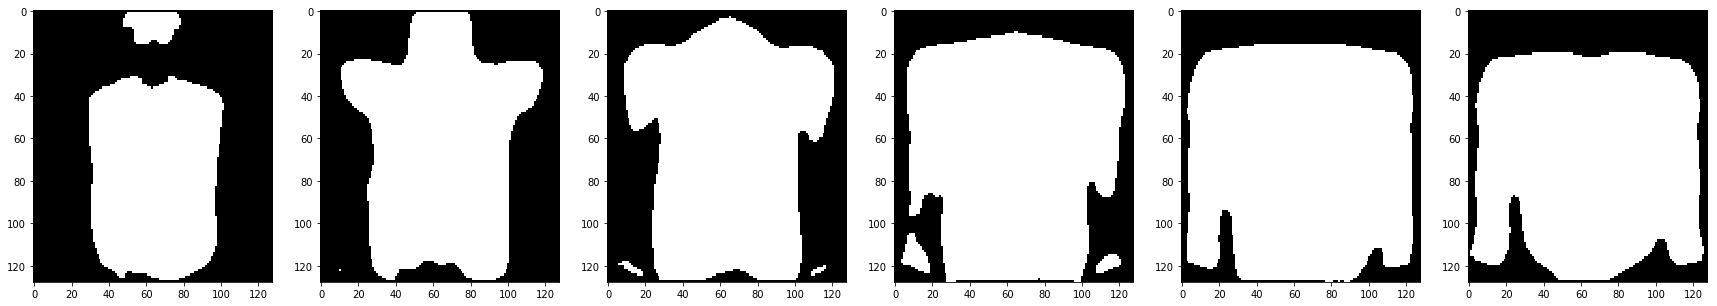

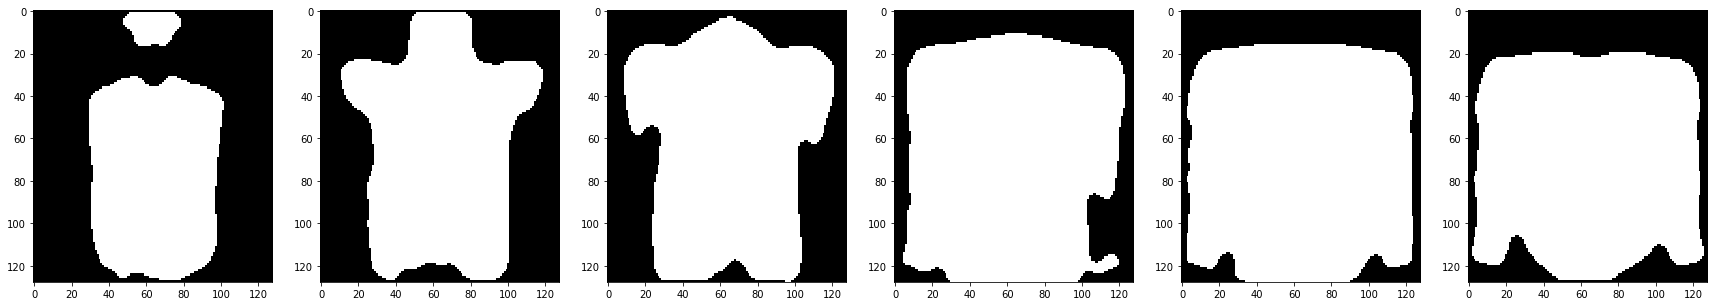

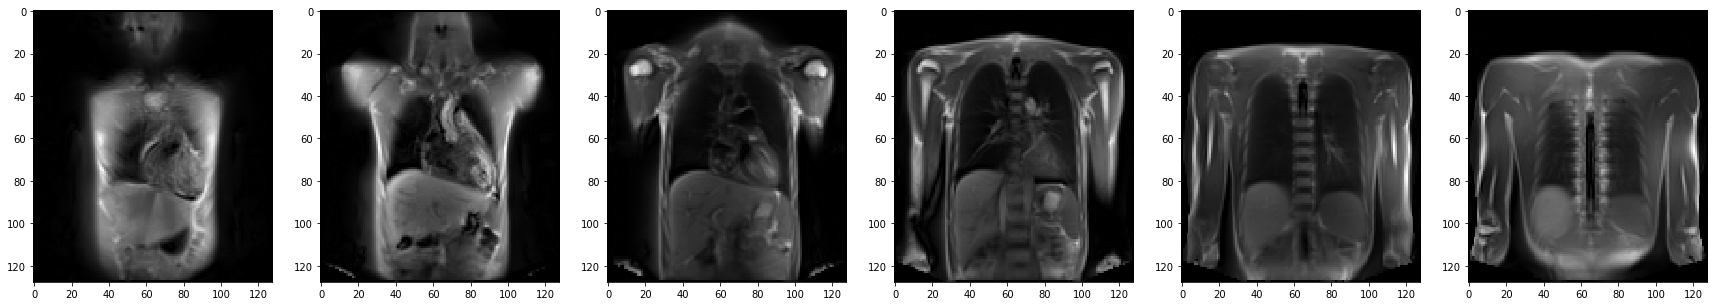

In [65]:
nrows=1
ncols=NumberSlice
plt.figure( figsize=(30,5))
for i in range(NumberSlice) :
    Slice = Segmentation[:,:,i]
    ax = plt.subplot(nrows,ncols,i+1)
    im=plt.imshow(np.rot90(Slice,1), aspect="auto", cmap='gray')
plt.figure( figsize=(30,5))
for i in range(NumberSlice) :
    Slice = SegmentationNew[:,:,i]
    ax = plt.subplot(nrows,ncols,i+1)
    im=plt.imshow(np.rot90(Slice,1), aspect="auto", cmap='gray')
plt.figure( figsize=(30,5))
for i in range(NumberSlice) :
    Slice = Dyn_data[:,:,i,0]
    ax = plt.subplot(nrows,ncols,i+1)
    im=plt.imshow(np.rot90(Slice,1), aspect="auto", cmap='gray')


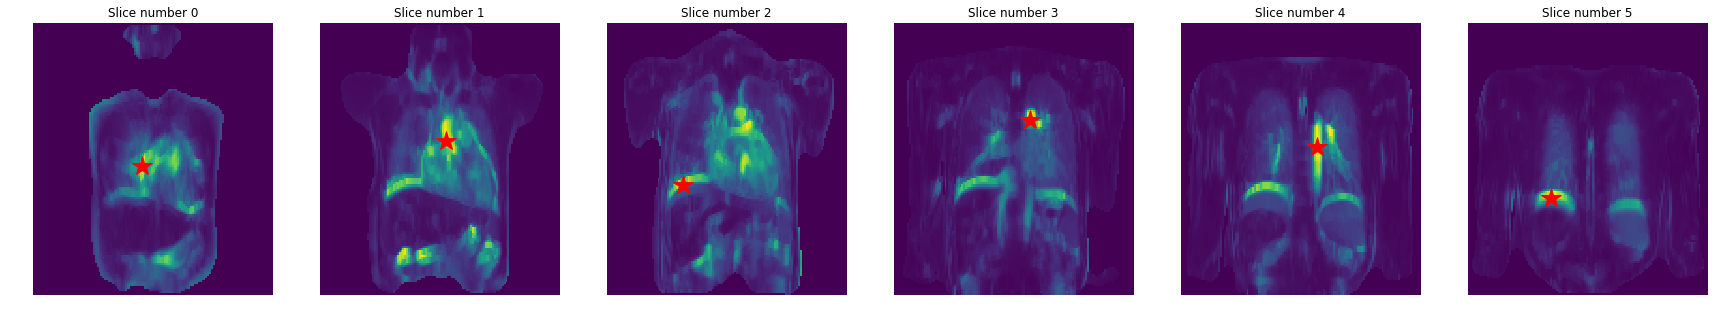

In [66]:

#Calculate the std matrix along the time dimension, but only on time interval (ie, half acquisition)
TimeInterval = np.arange(1,np.int(np.ceil(Dyn_data.shape[3]/2)),1)
MatrixStd =  MakeStdMatrix(Dyn_data,TimeInterval)
# Put margins to zero, just to be sure

MatrixStd =MatrixStd * SegmentationNew

#Display results
nrows=1
ncols=NumberSlice
plt.figure( figsize=(30,5))
for i in range(NumberSlice) :
    Slice = MatrixStd[:,:,i]
    ax = plt.subplot(nrows,ncols,i+1)
    im=plt.imshow(np.rot90(Slice,1), aspect="auto")
    MaxPos = maximum_position(MatrixStd[:,:,i ])
    plt.plot(MaxPos[0], MatrixStd.shape[0] - MaxPos[1], 'r*',  markersize=20)
    plt.axis('off')
    plt.title('Slice number {0:.0f}'.format(i))



Select the slice to work with - generally last one. Is the red dot indicating the diaphragm?


In [12]:
SliceNum = NumberSlice-1
#The position of the diaphgram is chosen as the highest value in the selected slice
PosDiaph = maximum_position(MatrixStd[:,:,SliceNum ]) #max of the variation!
Positions=np.zeros((NAverages*NumTI ,NumberSlice ))
Positions1=np.zeros((NAverages,NumTI ))
#We need to select a (vertical) interval around which to search for the actual diaphragm position in each slice and each repetition
VerticalIntervalAroundD = 20
#A second interval is identified for a second round of selection in 'difficult' images (ie, TI=300 ms)
SecondVerticalIntervalAroundD = 5
TI_to_search_twice = 300
Ind_TI= np.where(NumbersTISorted == TI_to_search_twice)
#To increase SNR we can avarage in the orizontal direction - diaphragm should be quite flat at apex
HorizontalIntervalAroundD = 4
IntervalWithout300 = np.concatenate((np.arange(Ind_TI[0]*NAverages), np.arange( ((Ind_TI[0]+1))*NAverages, NumTI*NAverages,1)))

for sslice in range(NumberSlice):
    Navigator = T1_data_reorder[PosDiaph[0]-HorizontalIntervalAroundD :PosDiaph[0] +HorizontalIntervalAroundD ,PosDiaph[1]-VerticalIntervalAroundD :PosDiaph[1]+VerticalIntervalAroundD,sslice ,:]
    #average in the orizontal direction
    Nav = np.array(np.mean(Navigator,0))
    #First derivative along vertical dimension
    Diff = np.diff(Nav,axis = 0)
    #Lung Liver interface is the minimum of the first derivative
    Positions[:,sslice] = np.argmin(Diff,0) #Lung Liver interface
    #find most common diaphragm position - this will be our target for this slice
    Common = stats.mode(Positions[IntervalWithout300,sslice],0)
    #find lung-liver interface around a smaller interval for TI = 300
    Diff[0:np.int(Common[0]-SecondVerticalIntervalAroundD), int(Ind_TI[0])*NAverages: (int(Ind_TI[0]+1))*NAverages] =100
    Diff[np.int(Common[0]+SecondVerticalIntervalAroundD):VerticalIntervalAroundD*2, int(Ind_TI[0])*NAverages: (int(Ind_TI[0]+1))*NAverages] =100
    Positions[:,sslice] = np.argmin(Diff,0) #Lung Liver interface

#choose most common position, without considering less interesting TI  =300ms
MostCommon,a= stats.mode(Positions[IntervalWithout300,:],0)
Distances =np.abs(Positions-MostCommon[0,:])

#find which acquisition has the diaphragm in the right position or close there
Target =np.zeros((NumberSlice,NumTI))


for TI in range(NumTI):
    for sslice in range(NumberSlice):
        Target[sslice,TI] = np.argmin(Distances[TI*NAverages:TI*NAverages+NAverages,sslice]) +1

print('Targets identified!')
print(' Check there are no error messages before moving to the next cells')                                          


Targets identified!
 Check there are no error messages before moving to the next cells


Use the following fields for dataset 003
Here are the results:
	"PERSLICE": {
		"image_index_sl001": "[1, 2, 1, 1, 2, 2]",
		"image_index_sl002": "[1, 1, 5, 1, 4, 1]",
		"image_index_sl003": "[1, 1, 2, 1, 2, 2]",
		"image_index_sl004": "[3, 1, 4, 1, 5, 1]",
		"image_index_sl005": "[3, 1, 4, 3, 5, 3]",
		"image_index_sl006": "[3, 5, 1, 4, 5, 4]",
		"ref_slices": "sn000027"},
***** File /Volumes/Data/L-ROY-16-23/patient-data/003/analysis/study-index_try.json updated *****
Have a look at the diaphragm position in all acquisitions, slice by slice


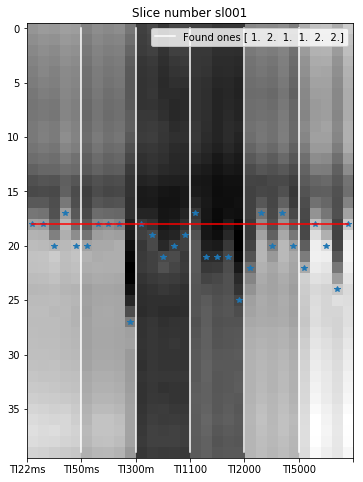

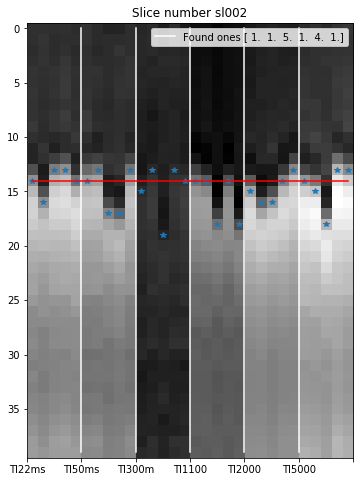

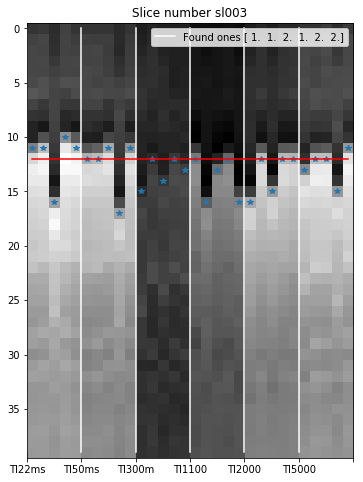

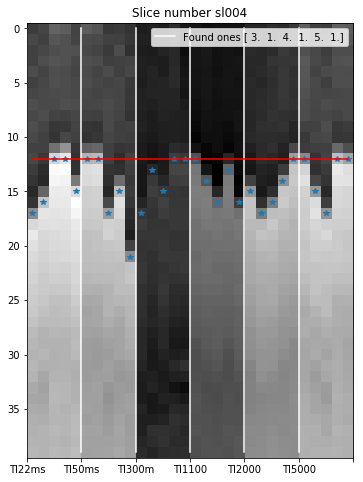

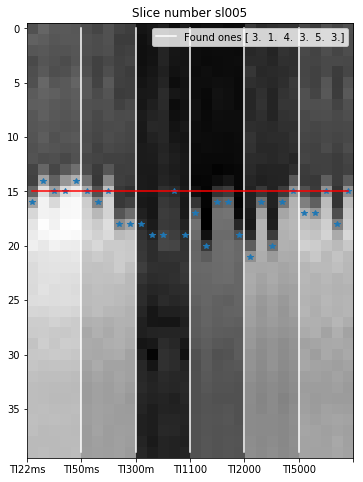

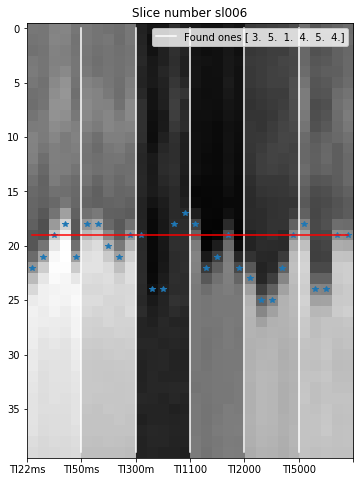

In [17]:

for sslice in range(NumberSlice):
    Navigator = T1_data_reorder[PosDiaph[0]-HorizontalIntervalAroundD :PosDiaph[0] +HorizontalIntervalAroundD ,PosDiaph[1]-VerticalIntervalAroundD :PosDiaph[1]+VerticalIntervalAroundD,sslice ,:]
    #average in the orizontal direction
    Nav = np.array(np.mean(Navigator,0))
    plt.figure( figsize=(8,8))
    fig= plt.imshow(np.flip(Nav,0), cmap='gray')
    ax = plt.gca();
    #make a grid
    for nTI in range(NumTI):
        plt.plot(np.ones((VerticalIntervalAroundD*2,1))*NAverages*nTI-0.5, np.arange(0,VerticalIntervalAroundD*2 ,1), 'w')
    plt.plot((VerticalIntervalAroundD*2-1)- Positions[:,sslice],'*')

    Line = np.ones((NAverages*NumTI,1))*np.int( MostCommon[0,sslice])
    plt.plot((VerticalIntervalAroundD*2-1)- Line,'r-')
    for key, value in DictSl.items():
        if value == sslice:
            plt.title('Slice number {0:s}'.format(key ))

    ax.set_xticks(np.arange(-0.5, NAverages*NumTI , NAverages))
    ax.set_xticklabels(DictTI.keys());
    ax.legend(['Found ones {}'.format(Target[sslice,:])])
print('======================================================================================')
print('Use the following fields for dataset {}'.format(dataset))
print('Here are the results:')
# print('\t"TARGETS": {')
# print('\t\t"inversion_time": "22 50 1100 2000 5000", "image_index": "1 1 1 1 1"},')
print('\t"PERSLICE": {')   
for sslice in range(NumberSlice):
    print('\t\t"image_index_{}": "{}",'.format(slxxx[sslice],list(map(int,Target[sslice,:]))))
print('\t\t"ref_slices": "{}"'.format(snxxx)+'},')
# print('\t"COMMON": {')
# print('\t\t"var_inv_pattern": "*{}*",\n\t\t"dyn_pattern": "*{}*"'.format(T1mapPattern, DynPattern)+'}')
print('======================================================================================')

TargList = [list(map(int,xt)) for xt in Target]
PIPELINECONTROLLERCONFIG ={}
PIPELINECONTROLLERCONFIG['PERSLICE']= {"ref_slices": '{}'.format(snxxx)}
for sl, iList in zip(DictSl, TargList): 
    PIPELINECONTROLLERCONFIG['PERSLICE'].update({'image_index_{}'.format(sl): ' '.join(list(map(str,iList)))})
write2StudyIndex(os.path.join(Path2Analysis, 'study-index.json'), 
                 'pipelineControllerConfig',
                 PIPELINECONTROLLERCONFIG) 
print('======================================================================================')
print('Have a look at the diaphragm position in all acquisitions, slice by slice')



    

Finally, if you want you can check the chosen images... is the red line indicating the diaphragm position everywhere? 

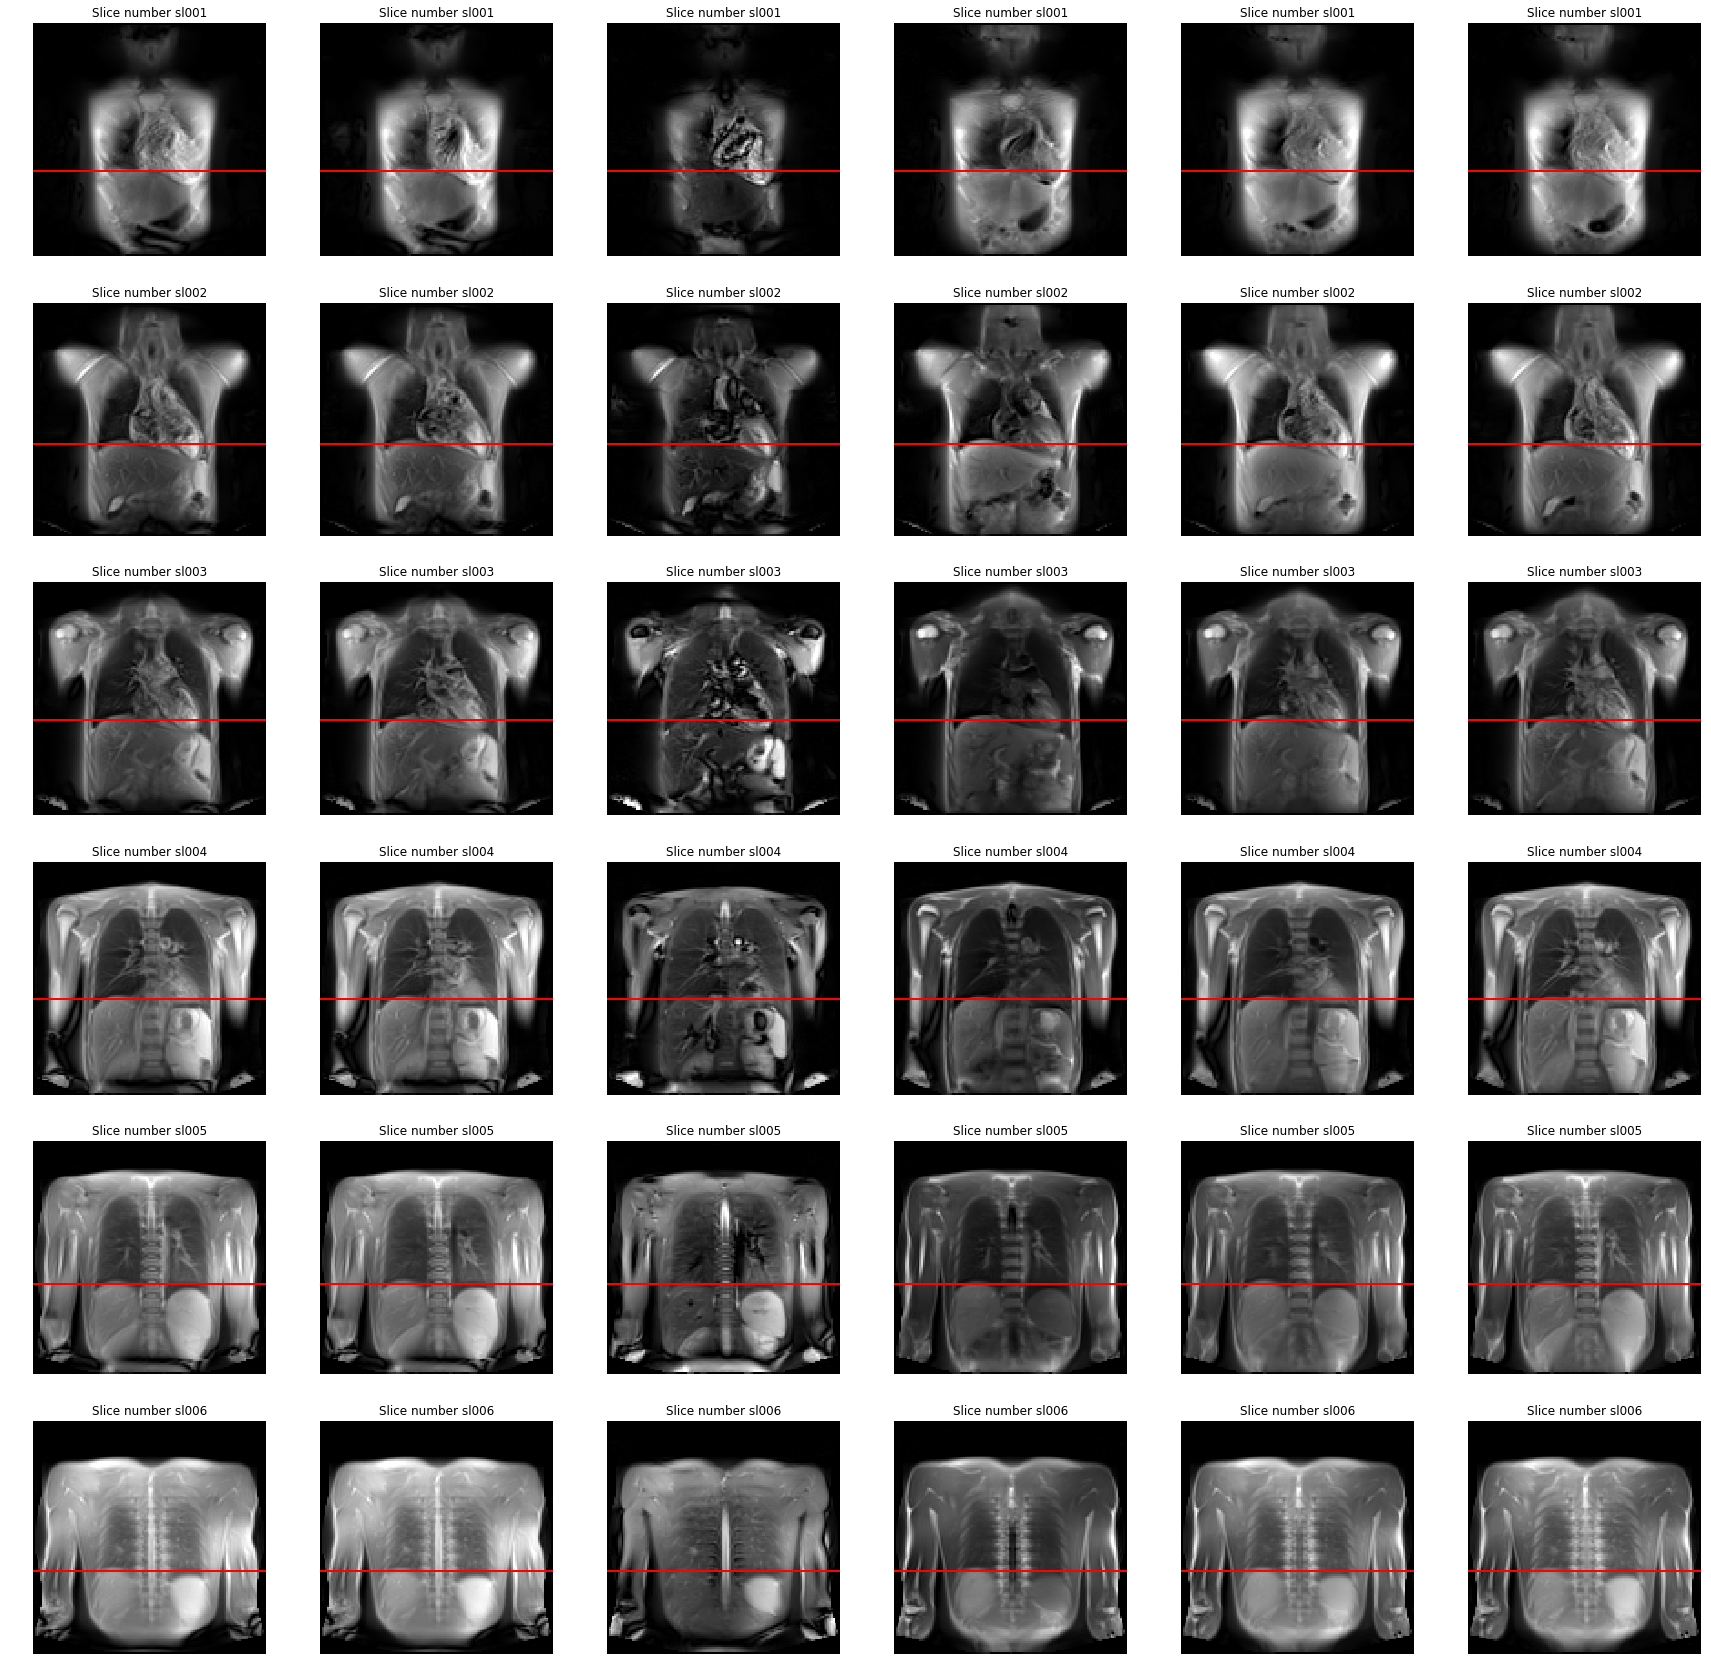

In [18]:
plt.figure( figsize=(30,30))
for sslice in range(NumberSlice):
    for i in range(NumTI):
        ind = int(Target[sslice,i]-1)
        Slice =  T1_data[:,:,sslice,i,ind ]
        Slice = Slice.squeeze()
        ax = plt.subplot(NumberSlice,NumTI,sslice*NumberSlice+i+1)
        im=plt.imshow(np.rot90(Slice,1),vmax= np.max(Slice)*0.9, cmap='gray')
        Line = np.ones((Data.shape[0],1))*np.int( Data.shape[0] - PosDiaph[1] +(VerticalIntervalAroundD-MostCommon[0,sslice]) )
        plt.plot( Line,'r-', linewidth=2)
        plt.axis('off')
        for key, value in DictSl.items():
            if value == sslice:
                plt.title('Slice number {0:s}'.format(key ))
